ICA test code

In [6]:
import torch
import os
import pdb
import numpy as np
import glob

def _standardize(X):
    mu = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    return (X - mu) / std

def _logcosh(x):
    # s always has real part >= 0
    s = np.sign(x) * x
    p = np.exp(-2 * s)
    return s + np.log1p(p) - np.log(2)

def kurtosis(X):
    mu = X.mean(axis=0)
    centered_X = X - mu
    moment4 = np.mean(centered_X ** 4, axis=0)
    moment2 = np.mean(centered_X ** 2, axis=0) + 1e-8
    kurt = moment4 / (moment2 ** 2)
    return kurt

def negentropy(X):
    a = 1
    X = _standardize(X)

    G1 = lambda u: 1 / a * (_logcosh(a * u))
    G2 = lambda u: -np.exp(-u ** 2 / 2)
    v = np.random.normal(0, 1, size=X.shape)

    E_G1_X = np.mean(G1(X), axis=0)
    E_G1_v = np.mean(G1(v), axis=0)

    return (E_G1_X - E_G1_v)**2


def non_gaussianality(dataset, emb_dim): 
    for class_name in os.listdir(dataset):
        files = sorted(glob.glob(f"{dataset}/{class_name}/*.pt"))
        embeds = []
        [embeds.append(torch.load(f)) for f in files]
        embeds = torch.stack(embeds, dim=0)
        embeds = embeds.view(-1, emb_dim)
        embeds = embeds[~torch.all(embeds == 0, dim=1)]
        embeds = embeds.data.cpu().numpy()


        if np.isnan(embeds).any():
            print(f"Class {class_name} embeds has NaNs")
            pdb.set_trace()
    
        kurt = kurtosis(embeds)
        neg_ent = negentropy(embeds)

        if np.isnan(kurt).any():
            print(f"Class {class_name} kurt has NaNs")
            pdb.set_trace()
        if np.isnan(neg_ent).any():
            print(f"Class {class_name} neg_ent has NaNs")
            pdb.set_trace()

        print(f"Class: {class_name}")
        print(f"Kurtosis: {kurt - 3}")
        print(f"Negentropy: {neg_ent}")
        print(f"Kurtosis sum: {kurt.sum() - 3}")
        print(f"Negentropy sum: {neg_ent.sum()}\n")


dataset = './data/512_20/emb_150/'
emb_dim = 1024
non_gaussianality(dataset, emb_dim)

Class: EC
Kurtosis: [-3. -3. -3. ... -3. -3. -3.]
Negentropy: [0.14047343 0.14035276 0.14008662 ... 0.137034   0.13771268 0.13757002]
Kurtosis sum: 9409.154296875
Negentropy sum: 115.43343481951098

Class: MC
Kurtosis: [-3. -3. -3. ... -3. -3. -3.]
Negentropy: [0.1463303  0.13960891 0.13687744 ... 0.14494987 0.13773397 0.14117462]
Kurtosis sum: 29949.6640625
Negentropy sum: 116.32932360381983

Class: HGSC
Kurtosis: [-3. -3. -3. ... -3. -3. -3.]
Negentropy: [0.13984441 0.14230767 0.14064554 ... 0.14011873 0.13930658 0.13997639]
Kurtosis sum: 166915.21875
Negentropy sum: 118.25674503439717

Class: CC
Kurtosis: [-3. -3. -3. ... -3. -3. -3.]
Negentropy: [0.13982104 0.13655188 0.1392655  ... 0.13463984 0.14236333 0.13949091]
Kurtosis sum: 6486.7109375
Negentropy sum: 115.36955167309262

Class: LGSC
Kurtosis: [-3. -3. -3. ... -3. -3. -3.]
Negentropy: [0.13373561 0.13717633 0.13818732 ... 0.13635834 0.14568523 0.14166497]
Kurtosis sum: 2870.641845703125
Negentropy sum: 114.59888445538363



OOD Rejection performance thresholded by energy scores. ID = major cancer, OOD = rare cancer

In [ ]:
from utils_ovca import generate_embeds_and_scores

model_weights_path = './model/dense/4/'
root_dir = './data/512_20/patches/Tumor/'
out_dir = './data/512_20/id_1'
save = True

scores, bin_cls = generate_embeds_and_scores(root_dir, model_weights_path, out_dir, save=save)

In [ ]:
from utils_ovca import generate_attentions_and_scores

root_dir = './data/512_20/id_1'
model_weights_path = './model/attn/0/model_end.pth'
out_dir = './data/512_20/id_1/'
save = True
debug = False

scores_all, cls_all = generate_attentions_and_scores(root_dir, model_weights_path, out_dir, save=save, debug=debug)

In [1]:
import sys
import numpy as np
import sklearn.metrics as sk


recall_level_default = 0.95

def stable_cumsum(arr, rtol=1e-05, atol=1e-08):
    """Use high precision for cumsum and check that final value matches sum
    Parameters
    ----------
    arr : array-like
        To be cumulatively summed as flat
    rtol : float
        Relative tolerance, see ``np.allclose``
    atol : float
        Absolute tolerance, see ``np.allclose``
    """
    out = np.cumsum(arr, dtype=np.float64)
    expected = np.sum(arr, dtype=np.float64)
    if not np.allclose(out[-1], expected, rtol=rtol, atol=atol):
        raise RuntimeError('cumsum was found to be unstable: '
                           'its last element does not correspond to sum')
    return out

def fpr_and_fdr_at_recall(y_true, y_score, recall_level=recall_level_default, pos_label=None):
    classes = np.unique(y_true)
    if (pos_label is None and
            not (np.array_equal(classes, [0, 1]) or
                     np.array_equal(classes, [-1, 1]) or
                     np.array_equal(classes, [0]) or
                     np.array_equal(classes, [-1]) or
                     np.array_equal(classes, [1]))):
        raise ValueError("Data is not binary and pos_label is not specified")
    elif pos_label is None:
        pos_label = 1.

    # make y_true a boolean vector
    y_true = (y_true == pos_label)

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # y_score typically has many tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve.
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = stable_cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps      # add one because of zero-based indexing

    thresholds = y_score[threshold_idxs]

    recall = tps / tps[-1]

    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1) 
    recall, fps, tps, thresholds = np.r_[recall[sl], 1], np.r_[fps[sl], 0], np.r_[tps[sl], 0], thresholds[sl]

    cutoff = np.argmin(np.abs(recall - recall_level))

    return fps[cutoff] / (np.sum(np.logical_not(y_true))) 

def get_measures(_pos, _neg, recall_level=0.95, max_value=sys.float_info.max):
    '''
    :param pos: outlier or wrongly predicted example scores
    :param neg: inlier or correctly predicted scores
    '''
    _pos = np.array(_pos[:]).reshape((-1, 1))
    _neg = np.array(_neg[:]).reshape((-1, 1))

    # Filter out NaN, infinity, and very large values in softmax-MLP cz the model predictions are trash :') <- is this still true I honestly don't know anymore
    _pos = _pos[~np.isnan(_pos)]
    _neg = _neg[~np.isnan(_neg)]
    _pos = _pos[np.isfinite(_pos)]
    _neg = _neg[np.isfinite(_neg)]
    _pos = np.clip(_pos, None, max_value)
    _neg = np.clip(_neg, None, max_value)
    _pos = _pos.reshape((-1, 1))
    _neg = _neg.reshape((-1, 1))

    examples = np.squeeze(np.vstack((_pos, _neg)))
    labels = np.zeros(len(examples), dtype=np.int32)
    labels[:len(_pos)] += 1  # outliers are labeled as 1

    auroc = sk.roc_auc_score(labels, examples)
    aupr = sk.average_precision_score(labels, examples)
    fpr = fpr_and_fdr_at_recall(labels, examples, recall_level)

    return auroc, aupr, fpr



In [20]:
from utils_ovca import load_scores

# Patch level
id_pth = '/projects/ovcare/classification/cshi/OoD/data/512_20/id_1/scores'
ood_pth = '/projects/ovcare/classification/cshi/OoD/data/512_20/ood_1/scores'
id_scores = load_scores(id_pth)
ood_scores = load_scores(ood_pth)
scores = ['xent', 'T calibrated', 'softmax-MLP']

for i in range(3):
    '''
    Displays out scores as positive
    '''
    auroc, aupr, fpr = get_measures(ood_scores[i], id_scores[i])
    print(f'\t\t\t Score {scores[i]}')
    print('AUROC:\t\t\t{:.2f}'.format(100 * auroc))
    print('AUPR:\t\t\t{:.2f}'.format(100 * aupr))
    print('FPR95:\t\t\t{:.2f}'.format(100 * fpr))

			 Score xent
AUROC:			64.59
AUPR:			28.82
FPR95:			97.63
			 Score T calibrated
AUROC:			66.58
AUPR:			29.61
FPR95:			94.62
			 Score softmax-MLP
AUROC:			53.94
AUPR:			22.55
FPR95:			84.70


In [15]:
from utils_ovca import load_scores, generate_attentions_and_scores
import os

# Slide level
id_pth = './data/512_20/id_1'
model_pth = './model/attn/0/model_end.pth'
ood_pth = './data/512_20/ood_1/scores'
id_scores = generate_attentions_and_scores(id_pth, model_pth, output_dir='', save=False)
ood_scores = load_scores(ood_pth)
scores = ['xent', 'T calibrated', 'softmax-MLP']
classes = os.listdir(os.path.join(id_pth, 'scores'))

for i in range(3):
    '''
    Displays out scores as positive
    '''
    for j in range(5):
        _scores = np.array(id_scores[0][j][:,i])
        auroc, aupr, fpr = get_measures(ood_scores[i], _scores)
        print(f'\t\t\t Score {scores[i]}, Class {classes[j]}')
        print('AUROC:\t\t\t{:.2f}'.format(100 * auroc))
        print('AUPR:\t\t\t{:.2f}'.format(100 * aupr))
        print('FPR95:\t\t\t{:.2f}'.format(100 * fpr))

			 Score xent, Class EC
AUROC:			80.43
AUPR:			99.84
FPR95:			98.31
			 Score xent, Class MC
AUROC:			83.31
AUPR:			99.96
FPR95:			69.23
			 Score xent, Class HGSC
AUROC:			83.87
AUPR:			99.77
FPR95:			94.88
			 Score xent, Class CC
AUROC:			80.48
AUPR:			99.88
FPR95:			91.02
			 Score xent, Class LGSC
AUROC:			78.91
AUPR:			99.95
FPR95:			78.26
			 Score T calibrated, Class EC
AUROC:			83.95
AUPR:			99.87
FPR95:			91.98
			 Score T calibrated, Class MC
AUROC:			87.15
AUPR:			99.97
FPR95:			49.23
			 Score T calibrated, Class HGSC
AUROC:			83.61
AUPR:			99.77
FPR95:			94.15
			 Score T calibrated, Class CC
AUROC:			85.08
AUPR:			99.91
FPR95:			80.84
			 Score T calibrated, Class LGSC
AUROC:			80.41
AUPR:			99.95
FPR95:			72.46
			 Score softmax-MLP, Class EC
AUROC:			79.13
AUPR:			99.77
FPR95:			68.78
			 Score softmax-MLP, Class MC
AUROC:			89.82
AUPR:			99.97
FPR95:			26.15
			 Score softmax-MLP, Class HGSC
AUROC:			13.16
AUPR:			97.28
FPR95:			100.00
			 Score softmax-MLP, Class CC

Accuracy and F1 scores

In [6]:
import torch
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from models.kimianet_virtual import KimiaNet
from mil.varmil import VarMIL
from ovca import OVCA, OVMIL
from utils_ovca import preprocess_load


# Compute F1 and accuracy scores
def evaluate(model, test_loader):
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            pred = outputs.data.max(1)[1]
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average="weighted")
    acc = accuracy_score(y_true, y_pred)
    return f1, acc

# Patch level classification
test_split = './data/512_20/splits/split.1_2_train_3_eval.json'
model_weights_path = './model/dense/4/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 5  # Number of classes
model = KimiaNet(num_classes=num_classes)
model.load_state_dict(preprocess_load(os.path.join(model_weights_path, 'net.pt'), ngpu=1))
model.to(device)
model.eval()

# Create test dataset and DataLoader
mean = [x / 255 for x in [207.79, 177.028, 209.72]]
std = [x / 255 for x in [28.79, 33.26, 18.41]]
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
labels = ['EC', 'CC', 'HGSC', 'LGSC', 'MC']
test_dataset = OVCA(test_split, chunk=2, test_transform=test_transform, idx_to_label=labels)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# Evaluate the model
f1, acc = evaluate(model, test_loader)

# Print results
print(f'F1 score: {f1:.4f}')
print(f'Accuracy: {acc:.4f}')


F1 score: 0.7380
Accuracy: 70.9100


In [7]:
# Slide level classification

test_split = './data/512_20/splits/split.1_2_train_3_eval_att.json'
model_weights_path = './model/attn/1/model_end.pth'
labels = ['EC', 'CC', 'HGSC', 'LGSC', 'MC']

model = VarMIL()
model.load_state_dict(preprocess_load(os.path.join(model_weights_path, 'net.pt'), ngpu=1))
model.to(device)
model.eval()

test_set = OVMIL(test_split, split=2, histotypes=labels)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=4)
f1, acc = evaluate(model, test_loader)

print(f'F1 score: {f1:.4f}')
print(f'Accuracy: {acc:.4f}')

F1 score: 0.8085
Accuracy: 82.6500


Heatmap code

In [ ]:
import os
import re
import glob
import torch

def natural_sort_key(s):
    return [int(t) if t.isdigit() else t for t in re.split(r'(\d+)', s)]

def indices_to_replace(emb_pths, k=5):
    '''
    Requires emb and att pths to be the same except by the word 'embeds' and 'att'
    '''
    att_pths = [pth.replace('embeds', 'att') for pth in emb_pths]
    indices = []
    for pth in att_pths:
        att = torch.load(pth).squeeze()
        _, topk_id = att.topk(k)
        indices.append(topk_id.data.cpu().numpy().tolist())
    return indices

def patches_for_replacement(emb_pths, indices, ptch_root_dir):
    '''
    Requires emb and ptch_root_dir to follow specific structure: root/{cls}/*.png
        indices: list of lists of indices to replace for each slide
    Returns: list of lists of paths to patches to replace for each slide
    '''
    selected_ptch_pths_all = []
    for pth, sld_idxs in zip(emb_pths, indices):
        path_parts = pth.split('/')
        class_label = path_parts[-2]
        image_label = path_parts[-1].split('.')[0]
        sld_pth = os.path.join(ptch_root_dir, class_label, image_label, '512', '20')
        
        image_files = sorted(glob.glob(os.path.join(sld_pth, '*.png')), key=natural_sort_key)
        selected_ptch_pths = [image_files[index] for index in sld_idxs]
        selected_ptch_pths_all.append(selected_ptch_pths)
    return selected_ptch_pths_all

1 loop done
(512, 512)


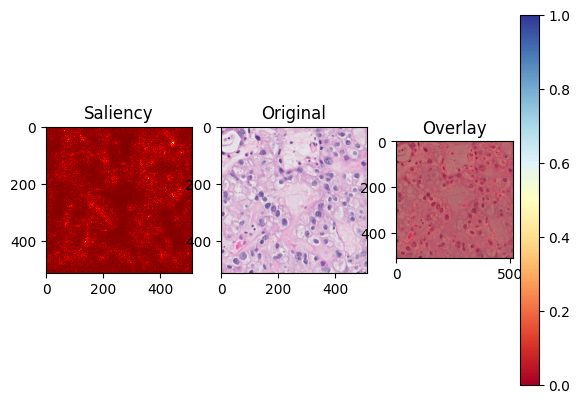

1 loop done
(512, 512)


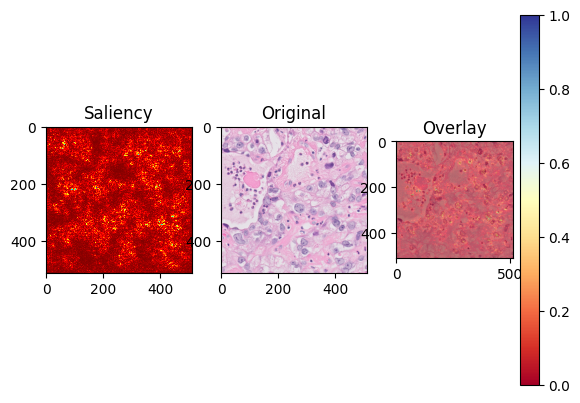

1 loop done
(512, 512)


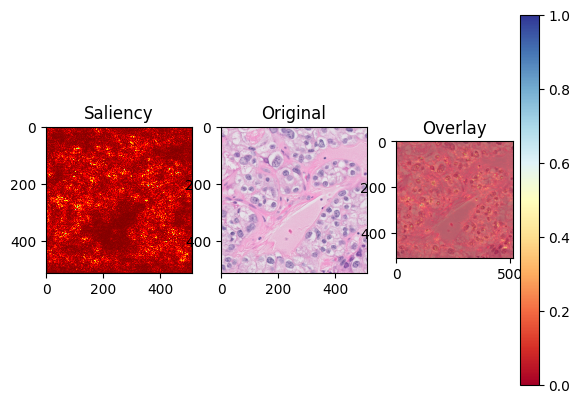

1 loop done
(512, 512)


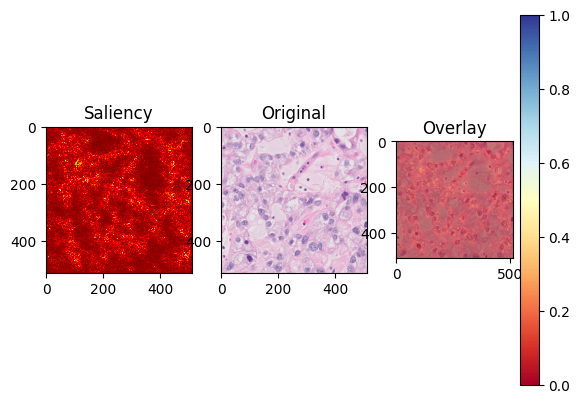

1 loop done
(512, 512)


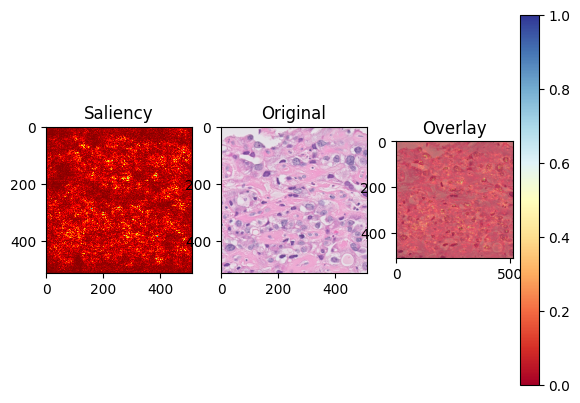

In [40]:
import torch
import torchvision
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.autograd import Variable
from mil.varmil import VarMIL
from models.kimianet_virtual import KimiaNet
from utils_ovca import preprocess_load

# Initialize models
load_net = './model/dense/4/net.pt'
load_att_net = './model/attn/0/model_end.pth'
ptch_root_dir = './data/512_20/patches/Tumor'
heatmap_dir = './data/512_20/id_1/heatmaps/ptch'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kimianet = KimiaNet(num_classes=5)
kimianet.load_state_dict(preprocess_load(load_net, ngpu=1))
varmil = VarMIL()
varmil.load_state_dict(preprocess_load(load_att_net, ngpu=1))
kimianet.to(device)
varmil.to(device)
kimianet.eval()
varmil.eval()

# List of tensor paths and indices to replace and patches to replace with
# Needs paths to be correlated! 
emb_paths = ['./data/512_20/id_1/embeds/CC/VOA-90A.pt']
indices_sld = indices_to_replace(emb_paths)
img_paths_sld = patches_for_replacement(emb_paths, indices_sld, ptch_root_dir)

transform = transforms.Compose([transforms.ToTensor()])

def store_grad(grad, idx):
    global grad_dict
    grad_dict[idx] = grad
grad_dict = {}


for tensor_path, replace_indices, img_pths in zip(emb_paths, indices_sld, img_paths_sld):
    varmil.zero_grad()
    kimianet.zero_grad()
    precomputed_emb = torch.load(tensor_path).to(device)
    
    # Replace 1 slide
    for idx, img_pth in zip(replace_indices, img_pths):
        img = cv2.imread(img_pth)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = transform(img_rgb).unsqueeze(0).to(device)
        img_tensor.requires_grad_()
        # img_tensor.register_hook(store_grad)
        img_tensor.register_hook(lambda grad, idx=idx: store_grad(grad, idx))
        out, img_emb = kimianet(img_tensor)
        precomputed_emb[idx] = img_emb.squeeze()

    output, _ = varmil(precomputed_emb.unsqueeze(0))
    output_idx = output.argmax()
    output_max = output[0, output_idx]
    output_max.backward()
    
    # Plot saliency
    for idx, img_pth in zip(replace_indices, img_pths):
        saliency = grad_dict[idx].squeeze().abs()
        saliency, _ = torch.max(saliency, dim=0)  # Need to max across channels!
        saliency = saliency.cpu().numpy()
        saliency = saliency / saliency.max()
        print("1 loop done")
        print(saliency.shape)

        saliency = cv2.applyColorMap(np.uint8(255 * saliency), cv2.COLORMAP_JET)

        img = cv2.imread(img_pth)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        overlay = cv2.addWeighted(img, 0.5, saliency, 0.5, 0)

        cmap = plt.cm.RdYlBu 
        figs, axs = plt.subplots(1, 3)
        im = axs[0].imshow(saliency, cmap=cmap, vmin=0, vmax=1, interpolation='nearest')
        axs[0].set_title('Saliency')
        axs[1].imshow(img)
        axs[1].set_title('Original')
        axs[2].imshow(overlay)
        axs[2].set_title('Overlay')
        cbar = axs[2].figure.colorbar(im, ax=axs[2])

        plt.pause(0.1)
        plt.show(block=False)
        
        sld_id = img_pth.split('/')[-4]
        os.makedirs(os.path.join(heatmap_dir, sld_id), exist_ok=True)
        cv2.imwrite(os.path.join(heatmap_dir, sld_id, f'overlay_{idx}.png'), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))


In [ ]:
import os
import torch
import numpy as np
import openslide
import cv2
from PIL import Image
from matplotlib import cm, colors

def parse_annotation_file(file_path):
    '''
    Parses the annotation file and returns a list of numpy arrays, where each array contains the coordinates of a tumor.
    Requires large ovarian dataset annotation format 
    '''
    with open(file_path, 'r') as f:
        lines = f.readlines()

    tumor_coords = []

    for line in lines:
        if line.startswith('Tumor'):
            coords_str = line.split(' ')[1:]
            coords = [tuple(map(float, coord.replace('Point:', '').strip().split(','))) for coord in coords_str]
            tumor_coords.append(np.array(coords))

    return tumor_coords

def get_patch_coordinates(sld_pths, ptch_root_dir):
    '''
    Returns a list of list of patch coordinates for each slide
    Requires the patch root directory to be structured as: <patch_root_dir>/<class_label>/<slide_id>/<patch_size>_<magnification>/<x_coord>_<y_coord>.png
    '''
    patch_coords = []
    for sld_pth in sld_pths:
        slide_id = os.path.basename(sld_pth).split('.')[0]
        class_label = os.path.basename(os.path.dirname(sld_pth))
        patch_dir = os.path.join(ptch_root_dir, class_label, slide_id, '512', '20')
        patch_coords.append([(int(pth.split('_')[-2]), int(pth.split('_')[-1].split('.')[0])) for pth in os.listdir(patch_dir)])
    return patch_coords
    
def get_attentions(sld_pths, att_root_dir):
    '''
    Returns a list of list of attentions for each slide
    '''
    atts = []
    for sld_pth in sld_pths:
        slide_id = os.path.basename(sld_pth).split('.')[0]
        class_id = sld_pth.split('/')[-2]
        att_pth = os.path.join(att_root_dir, class_id, f"{slide_id}.pt")
        att = torch.load(att_pth).squeeze().data.cpu().numpy()
        atts.append(att)
    return atts

def create_attention_heatmaps(image_paths, patch_coord, attentions, annotation_dir, output_dir, alpha=0.5):
    for img_path, img_bboxes, img_attentions in zip(image_paths, patch_coord, attentions):
        slide = openslide.OpenSlide(img_path)
        dimensions = slide.level_dimensions[-1]
        down_sample = slide.level_downsamples[-1]
        thumbnail = slide.get_thumbnail(dimensions)
        thumbnail_np = np.array(thumbnail.convert('RGB'))

        img_attentions_normalized = img_attentions[:len(img_bboxes)] / img_attentions[:len(img_bboxes)].max()
        cmap = cm.get_cmap('jet')

        # Process the annotation file
        sld_id = os.path.basename(img_path)
        sld_id, _ = os.path.splitext(sld_id)
        annotation_file = os.path.join(annotation_dir, f'{sld_id}.txt')
        tumor_annotations = parse_annotation_file(annotation_file)

        for tumor_coords in tumor_annotations:
            tumor_coords_downsampled = (tumor_coords / down_sample).astype(np.int32)
            cv2.polylines(thumbnail_np, [tumor_coords_downsampled], True, (0, 0, 255), 2, cv2.LINE_AA)

        for i, (bbox, att) in enumerate(zip(img_bboxes, img_attentions_normalized)):
            x, y = bbox
            x_down, y_down = int(x / down_sample), int(y / down_sample)
            w_down, h_down = int(512 / down_sample), int(512 / down_sample)

            rgba_color = cmap(att)
            bgr_color = (rgba_color[2] * 255, rgba_color[1] * 255, rgba_color[0] * 255)
            cv2.rectangle(thumbnail_np, (x_down, y_down), (x_down + w_down, y_down + h_down), bgr_color, -1, cv2.LINE_AA)

        overlay = cv2.addWeighted(thumbnail_np, 1 - alpha, np.array(thumbnail), alpha, 0)

        # Save the resulting image
        output_path = os.path.join(output_dir, f'{sld_id}_heatmap.png')
        os.makedirs(output_dir, exist_ok=True)
        cv2.imwrite(output_path, overlay)

In [ ]:
ptch_root_dir = './data/512_20/patches/Tumor'
att_root_dir = './data/512_20/id_1/att'
sld_pths = ['./data/WSI/ov984/HGSC/VOA-023B.tiff',
          './data/WSI/ov984/HGSC/VOA-011B.tiff']
annotation_dir = './data/WSI/ov984/annotations'
output_dir = './data/512_20/id_1/slide_heatmaps'
ptch_coords = get_patch_coordinates(sld_pths, ptch_root_dir)
atts = get_attentions(sld_pths, att_root_dir)
